In [1]:
from models.merge import CNN, BiLSTM, ELMo, Ensemble
from data.Dataset import Dataset
from data.TrainSet import TrainSet
from utils.utils import plot_words_cloud, plot_words_count, plot_compare_bars

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kmaltcev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read books

In [2]:
names = ["Furman", "Garshin"]
dataset = Dataset(names)
dataset.data

,label,author,text
0,0,Furman,﻿П. Р. Фурман\nСаардамский плотник\n \n\n184...
1,1,Garshin,﻿Всеволод Михайлович Гаршин\nНадежда Николаев...


Clean text from punctuation

In [3]:
dataset.preprocess()
dataset.data

Lemmatizing Furman:   0%|          | 0/14 [00:00<?, ?it/s][nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kmaltcev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kmaltcev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kmaltcev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kmaltcev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Preprocessing Garshin: 100%|██████████| 16832/16832 [00:03<00:00, 4397.82it/s]


,label,author,text
0,0,Furman,фурман саардамский плотник глава незнакомец на...
1,1,Garshin,всеволод михайлович гаршин надежда николаевна ...


VISUALIZING THE DATA

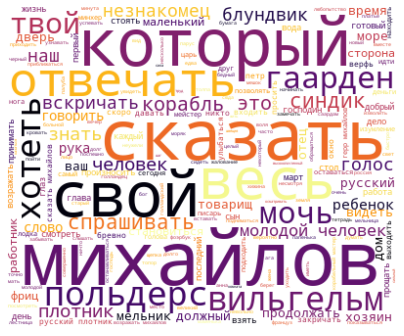

<Figure size 432x288 with 0 Axes>

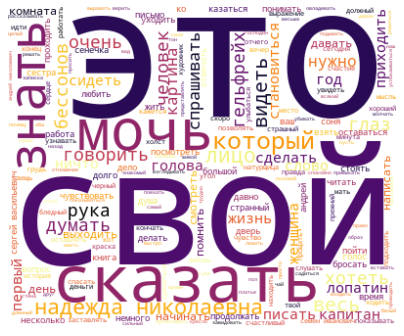

<Figure size 432x288 with 0 Axes>

In [4]:
plot_words_cloud(dataset.data)

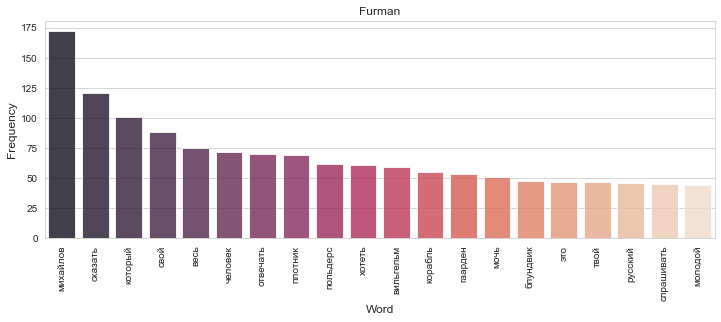

<Figure size 432x288 with 0 Axes>

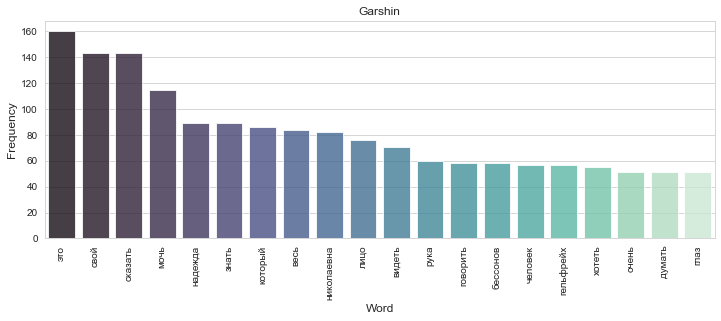

<Figure size 432x288 with 0 Axes>

In [5]:
plot_words_count(dataset.data)

Count and visualize as barplots

/Volumes/Data/Project/NLP-BiLSTM-model/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


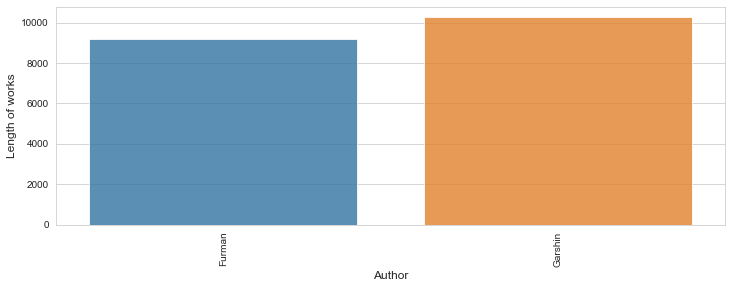

<Figure size 432x288 with 0 Axes>

In [6]:
plot_compare_bars(dataset.data)

In [7]:
dataset.chunking()
dataset.prep_data

,label,author,text
0,0,Furman,"[[фурман, саардамский, плотник, глава, незнако..."
0,1,Garshin,"[[всеволод, михайлович, гаршин, надежда, никол..."


In [9]:
dataset.embedding(ELMo)

ELMo embedding process:: 100%|██████████| 2/2 [00:00<00:00, 55.40it/s]2021-11-22 18:25:02,841 : INFO : Loading model from ./elmo/...

2021-11-22 18:25:02,844 : INFO : We will cache the vocabulary of 100 tokens.
2021-11-22 18:25:02,849 : INFO : Loading model from ./elmo/...
2021-11-22 18:25:02,852 : INFO : We will cache the vocabulary of 100 tokens.
2021-11-22 18:25:21,175 : INFO : Warming up ELMo on 40 sentences...
2021-11-22 18:25:21,191 : INFO : Warming up ELMo on 40 sentences...
2021-11-22 18:25:27,982 : INFO : Warming up finished.
2021-11-22 18:25:27,996 : INFO : Texts in the current batch: 40
2021-11-22 18:25:28,064 : INFO : Warming up finished.
2021-11-22 18:25:28,080 : INFO : Texts in the current batch: 40
2021-11-22 18:25:34,514 : INFO : Texts in the current batch: 40
2021-11-22 18:25:34,534 : INFO : Texts in the current batch: 40
2021-11-22 18:25:40,940 : INFO : Texts in the current batch: 40
2021-11-22 18:25:40,979 : INFO : Texts in the current batch: 40
2021-11-22 18:25:47,3

KeyboardInterrupt: 

In [9]:
dataset.prep_data

,label,author,text,embeddings
0,0,Furman,"[фурман, саардамский, плотник, глава, незнаком...","[[0.05083872005343437, -0.4665144979953766, -0..."
1,0,Furman,"[ровно, набегать, берег, оставлять, каменья, ж...","[[-0.16346034407615662, 0.38992828130722046, 0..."
2,0,Furman,"[берег, начинать, оживляться, остроконечный, к...","[[-0.2623555064201355, 0.17305420339107513, 0...."
3,0,Furman,"[черный, масса, полуоконченный, смоленый, судн...","[[0.30258357524871826, -0.368518590927124, -0...."
4,0,Furman,"[узкий, деревянный, лестница, выбеливать, мука...","[[0.7457689642906189, 0.1087607815861702, 0.84..."
...,...,...,...,...
251,1,Garshin,"[белый, лежать, пол, мочь, доставать, очень, э...","[[-0.3223157525062561, -0.6969047784805298, -0..."
252,1,Garshin,"[убивать, собирать, сила, приподниматься, увид...","[[0.16961704194545746, -0.40545496344566345, -..."
253,1,Garshin,"[семен, иванович, бросаться, ко, почувствовать...","[[-0.24074891209602356, 0.059847503900527954, ..."
254,1,Garshin,"[хлынуть, смертельный, рана, голова, кончать, ...","[[-0.22421275079250336, 0.08201383054256439, 0..."


In [10]:
train_set = TrainSet(dataset.prep_data)
train_set.shape

,Train,Test
X,"(412, 40, 1024)","(73, 40, 1024)"
Y,"(412, 3)","(73, 3)"


In [11]:
cnn = CNN(train_set.X_shape(), output_units=3)
cnn.build()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
cnn.plot_model()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
#cnn.fit(train_set)

In [14]:
bilstm = BiLSTM(train_set.X_shape(), hidden_state_dim=500)

In [15]:
bilstm.build()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [16]:
bilstm.plot_model()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Train on 350 samples, validate on 62 samples
Epoch 1/10


/Volumes/Data/Project/NLP-BiLSTM-model/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


350/350 - 6s - loss: 0.5463 - accuracy: 0.7314 - val_loss: 0.2948 - val_accuracy: 0.9194 - 6s/epoch - 17ms/sample
Epoch 2/10
350/350 - 5s - loss: 0.2033 - accuracy: 0.9143 - val_loss: 0.1925 - val_accuracy: 0.8871 - 5s/epoch - 15ms/sample
Epoch 3/10
350/350 - 6s - loss: 0.1257 - accuracy: 0.9571 - val_loss: 0.4067 - val_accuracy: 0.9032 - 6s/epoch - 18ms/sample
Epoch 4/10
350/350 - 5s - loss: 0.0633 - accuracy: 0.9857 - val_loss: 0.2226 - val_accuracy: 0.9194 - 5s/epoch - 14ms/sample
Epoch 5/10
350/350 - 5s - loss: 0.0288 - accuracy: 0.9914 - val_loss: 0.4908 - val_accuracy: 0.9032 - 5s/epoch - 14ms/sample
Epoch 6/10
350/350 - 5s - loss: 0.0155 - accuracy: 0.9971 - val_loss: 0.4860 - val_accuracy: 0.9355 - 5s/epoch - 14ms/sample
Epoch 7/10
350/350 - 5s - loss: 0.0073 - accuracy: 0.9971 - val_loss: 0.6119 - val_accuracy: 0.9194 - 5s/epoch - 14ms/sample
Epoch 8/10
350/350 - 5s - loss: 0.0065 - accuracy: 0.9971 - val_loss: 0.6789 - val_accuracy: 0.9194 - 5s/epoch - 14ms/sample
Epoch 9/10


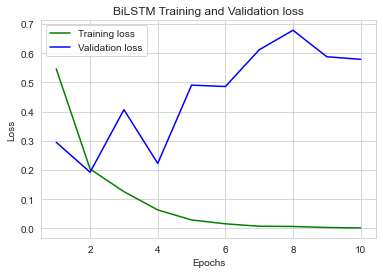

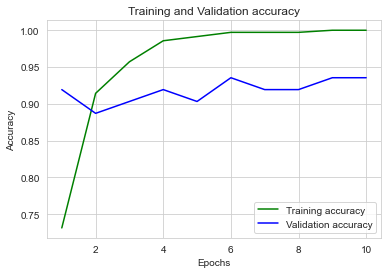

<Figure size 432x288 with 0 Axes>

In [17]:
bilstm.fit(train_set)

In [18]:
cnn_bilstm = Ensemble(cnn, bilstm, train_set)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Train on 412 samples
Epoch 1/10
412/412 [==============================] - 1s 4ms/sample - loss: 1.0431 - accuracy: 0.6869
Epoch 2/10
412/412 [=====================

2021-11-22 14:58:57.962621: W tensorflow/c/c_api.cc:349] Operation '{name:'bidirectional/backward_lstm_1_1/while' id:1654 op device:{requested: '', assigned: ''} def:{{{node bidirectional/backward_lstm_1_1/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, DT_FLOAT, DT_INT32, DT_VARIANT, DT_RESOURCE, DT_RESOURCE, DT_RESOURCE, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_outputs=46, _read_only_resource_inputs=[8, 9, 10], _stateful_parallelism=false, body=bidirectional_backward_lstm_1_1_while_body_2059_rewritten[], cond=bidirectional_backward_lstm_1_1_wh

Epoch 1/10
412/412 [==============================] - 19s 47ms/sample - loss: 0.4498 - accuracy: 0.9126
Epoch 2/10
412/412 [==============================] - 16s 39ms/sample - loss: 0.0691 - accuracy: 0.9830

In [19]:
cnn_bilstm.fit()

/Volumes/Data/Project/NLP-BiLSTM-model/venv/lib/python3.9/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


EnsembleVoteClassifier(clfs=[<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa4d1ae4520>,
                       fit_base_estimators=False, use_clones=False,
                       voting='soft')

In [20]:
cnn_bilstm.predict()

Using Testing Set for Classes Prediction


/Volumes/Data/Project/NLP-BiLSTM-model/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,

In [22]:
from data.TestSet import TestSet
from utils.constants import BOOKS_DIR

path = f"{BOOKS_DIR}/Sholokhov/and-quiet-flows-the-don.txt"
testing = TestSet(path, names, ELMo)

Embeddings not found, processing...


  1%|          | 8/1084 [00:09<20:44,  1.16s/it]

KeyboardInterrupt: 

In [ ]:
testing.preds = cnn_bilstm.predict()
testing.plot_prediction()

In [ ]:
import numpy as np

print("test")
testing.preds = np.array(cnn_bilstm.voting.predict(np.array(list(testing.dataframe['embeddings']))), dtype='uint8')
testing.plot_prediction()

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
cnts = [len(np.where(testing.preds == i)[0]) for i in range(2)]
fig = plt.figure(figsize=(12, 4))
fig.set_facecolor('white')

sns.barplot(testing.labels, cnts, alpha=0.8)
plt.ylabel('Chunks Attribution', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show()
plt.savefig(f"./plots/{testing.author}_{testing.work}.png")

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=testtin, y=y, clf=cnn_bilstm.voting)
